for 90 days

[Trial 45] Using device: cuda [I 2025-09-23 17:09:02,235] Trial 45 finished with value: 20.338580012234445 and parameters: {'seq_length': 1224, 'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.2, 'batch_size': 4, 'learning_rate': 0.002858971187361027, 'weight_decay': 1.3517592135839355e-05, 'optimizer': 'Adam', 'epochs': 400}. Best is trial 45 with value: 20.338580012234445.

 Best Value (RMSE): 21.912181013258643
✅ Best hyperparameters: {'seq_length': 216, 'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.30000000000000004, 'batch_size': 8, 'learning_rate': 0.00028715589458236325, 'weight_decay': 1.4456647707796516e-05, 'optimizer': 'RMSprop', 'epochs': 500}

In [16]:
import requests
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

import random


In [17]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [18]:
def fetch_eth_data():

    url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart"
    params = {"vs_currency": "usd", "days": "90"}
    response = requests.get(url, params=params)
    data = response.json()
    print(data)

    # print(f"{data['prices']}")

    timestamp = [p[0] for p in data["prices"]]
    price = [p[1] for p in data["prices"]]  # [timestamp, price]

    return np.array(price).reshape(-1, 1), np.array(timestamp)

price, timestamp = fetch_eth_data()
print("Fetched data shape:", price)


{'prices': [[1753319372555, 3646.543042249557], [1753322701313, 3645.916376217], [1753326566793, 3649.56747365653], [1753330142202, 3649.9677314167498], [1753333740285, 3615.965395684887], [1753337182715, 3565.580675598075], [1753340966219, 3530.3032107775402], [1753344543913, 3578.122368332214], [1753348158084, 3636.7659865602304], [1753351769361, 3647.3667056080344], [1753355071401, 3621.6394047497856], [1753358774002, 3659.114465849132], [1753362248562, 3629.0982114054923], [1753365858709, 3639.165245552333], [1753369484340, 3709.851266725574], [1753373059639, 3730.017064255953], [1753376877348, 3692.6407932254474], [1753380255898, 3727.057915750924], [1753384161058, 3743.3614150370167], [1753387765015, 3734.082002134767], [1753391336512, 3740.6361721856033], [1753394972156, 3726.8522118392366], [1753398556472, 3722.384156402879], [1753402147652, 3701.450643553188], [1753405784859, 3659.7355864811966], [1753409318632, 3681.643284163204], [1753412933646, 3622.727071765376], [17534164

**PREPROCESSING**

In [19]:
price.shape

(2162, 1)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(price)

In [22]:
def create_sequences(data, seq_length):

    sequences,  targets = [], []

    for i in range(len(data) - seq_length): #722 - 168
        x = data[i:i+seq_length] #data[0:168], data[168:..], ..., data[..:722]
        y = data[i+seq_length]  #data[24], data[25], ..., data[167]
        sequences.append(x)
        targets.append(y)
    return np.array(sequences), np.array(targets)

seq_length = 1680

# X_all, y_all = create_sequences(scaled_prices, seq_length)

# print("Training shape:", X_all.shape, y_all.shape)


In [23]:
class CustomDataset(Dataset):
  def __init__(self, X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


In [24]:
# Prepare data
X_all, y_all = create_sequences(scaled_prices, seq_length)


train_size = int(len(X_all) * 0.8)
X_train = X_all[:train_size]
y_train = y_all[:train_size]
X_test = X_all[train_size:]
y_test = y_all[train_size:]

# Convert to torch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

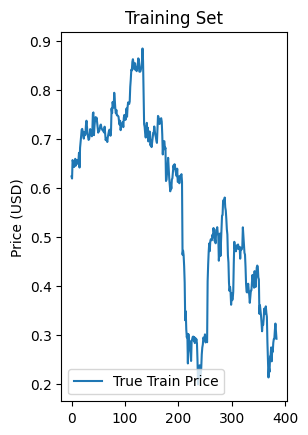

In [25]:
# Plot training predictions
plt.subplot(1, 2, 1)
plt.plot(y_train, label="True Train Price")
plt.title("Training Set")
plt.ylabel("Price (USD)")
plt.legend()

In [26]:
class LSTMwithANN(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
            # self.dropout1 = nn.Dropout(p=0.1)

            self.fc1 = nn.Linear(64, 32)
            self.relu = nn.ReLU()
            # self.dropout2 = nn.Dropout(p=0.1)
            self.fc2 = nn.Linear(32, 1)

        def forward(self, x):

            intermediate_hidden_states, (final_hidden_state, final_cell_state) = self.lstm(x)

            last_layer_hidden = final_hidden_state[-1]  # shape: [batch_size, hidden_size

            # output = self.dropout1(last_layer_hidden)

            output = self.fc1(last_layer_hidden)

            output = self.relu(output)

            # output = self.dropout2(output)

            output = self.fc2(output)

            return output

In [27]:
model = LSTMwithANN().to(device)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMwithANN(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

**TRAINING**

In [29]:
epochs = 2000
learning_rate = 0.0001

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate , weight_decay= 1.35e-05)

In [30]:
# training loop

#TRAINING LOOP
for epoch in range(epochs):
  total_loss = 0
  model.train()
  for batch_x, batch_y in train_loader:
      batch_x = batch_x.to(device)
      batch_y = batch_y.to(device)
      optimizer.zero_grad()
      preds = model(batch_x)
      loss = criterion(preds, batch_y)
      loss.backward()
      optimizer.step()

      total_loss = total_loss + loss.item()

  print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.4409
Epoch 2, Loss: 0.1164
Epoch 3, Loss: 0.0196
Epoch 4, Loss: 0.0151
Epoch 5, Loss: 0.0100
Epoch 6, Loss: 0.0086
Epoch 7, Loss: 0.0072
Epoch 8, Loss: 0.0066
Epoch 9, Loss: 0.0061
Epoch 10, Loss: 0.0055
Epoch 11, Loss: 0.0056
Epoch 12, Loss: 0.0053
Epoch 13, Loss: 0.0049
Epoch 14, Loss: 0.0045
Epoch 15, Loss: 0.0044
Epoch 16, Loss: 0.0041
Epoch 17, Loss: 0.0042
Epoch 18, Loss: 0.0041
Epoch 19, Loss: 0.0038
Epoch 20, Loss: 0.0036
Epoch 21, Loss: 0.0035
Epoch 22, Loss: 0.0034
Epoch 23, Loss: 0.0032
Epoch 24, Loss: 0.0031
Epoch 25, Loss: 0.0032
Epoch 26, Loss: 0.0032
Epoch 27, Loss: 0.0028
Epoch 28, Loss: 0.0028
Epoch 29, Loss: 0.0027
Epoch 30, Loss: 0.0026
Epoch 31, Loss: 0.0026
Epoch 32, Loss: 0.0024
Epoch 33, Loss: 0.0023
Epoch 34, Loss: 0.0024
Epoch 35, Loss: 0.0022
Epoch 36, Loss: 0.0022
Epoch 37, Loss: 0.0022
Epoch 38, Loss: 0.0022
Epoch 39, Loss: 0.0021
Epoch 40, Loss: 0.0020
Epoch 41, Loss: 0.0021
Epoch 42, Loss: 0.0020
Epoch 43, Loss: 0.0020
Epoch 44, Loss: 0.00

In [31]:
model.eval()

last_seq = X_test[-1].unsqueeze(0).to(device)  # last window
predicted = model(last_seq).detach().cpu().numpy()
predicted = scaler.inverse_transform(predicted)

current_price = price[-1][0]

# Convert the last timestamp to Michigan (local) time
utc_dt = datetime.utcfromtimestamp(timestamp[-1] / 1000)  # timestamps must be from fetch_eth_data()
michigan_time = utc_dt.astimezone(ZoneInfo("America/Detroit"))
predicted_time = michigan_time + timedelta(hours=1)

# Print results
print("Current ETH Price:", current_price)
print("Current Price Time (Michigan):", michigan_time.strftime("%Y-%m-%d %H:%M:%S %Z"))

print("Predicted Next Price:", predicted[0][0])
print("Predicted Price Time (Michigan):", predicted_time.strftime("%Y-%m-%d %H:%M:%S %Z"))

if predicted[0][0] > current_price:
    print("Advice: BUY")
else:
    print("Advice: SELL")

Current ETH Price: 3848.297716065675
Current Price Time (Michigan): 2025-10-21 20:49:53 EDT
Predicted Next Price: 3864.6038
Predicted Price Time (Michigan): 2025-10-21 21:49:53 EDT
Advice: BUY


/tmp/ipython-input-2571193858.py:10: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_dt = datetime.utcfromtimestamp(timestamp[-1] / 1000)  # timestamps must be from fetch_eth_data()


In [32]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:  #test data
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)

        all_predictions.append(preds.cpu().numpy())
        all_targets.append(batch_y.cpu().numpy())

# Concatenate all batches
all_predictions = np.vstack(all_predictions)
all_targets = np.vstack(all_targets)

# Inverse transform to original scale
test_predictions_orig = scaler.inverse_transform(all_predictions)
y_test_orig = scaler.inverse_transform(all_targets)

# Calculate metrics
test_mse = mean_squared_error(y_test_orig, test_predictions_orig)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_orig, test_predictions_orig)
test_r2 = r2_score(y_test_orig, test_predictions_orig)

percentage_errors = (test_predictions_orig.flatten() - y_test_orig.flatten()) / y_test_orig.flatten() * 100
mape = np.mean(np.abs(percentage_errors))

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2 Score: {test_r2:.4f}")


Mean Absolute Percentage Error (MAPE): 0.52%
Test MSE: 897.7230
Test RMSE: 29.9620
Test MAE: 20.4012
Test R2 Score: 0.8001


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model.eval()

all_train_preds = []
all_train_targets = []

with torch.no_grad():
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)

        all_train_preds.append(preds.cpu().numpy())
        all_train_targets.append(batch_y.cpu().numpy())

# Concatenate all batches
all_train_preds = np.vstack(all_train_preds)
all_train_targets = np.vstack(all_train_targets)

# Inverse transform to original scale
train_predictions_orig = scaler.inverse_transform(all_train_preds)
y_train_orig = scaler.inverse_transform(all_train_targets)

# Calculate metrics
train_mse = mean_squared_error(y_train_orig, train_predictions_orig)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_orig, train_predictions_orig)
train_r2 = r2_score(y_train_orig, train_predictions_orig)

percentage_errors = (train_predictions_orig.flatten() - y_train_orig.flatten()) / y_train_orig.flatten() * 100
mape = np.mean(np.abs(percentage_errors))

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

print(f"Train MSE: {train_mse:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R2 Score: {train_r2:.4f}")



Mean Absolute Percentage Error (MAPE): 0.59%
Train MSE: 1200.5837
Train RMSE: 34.6494
Train MAE: 25.0914
Train R2 Score: 0.9852


In [34]:
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

print(f"Train R2 Score: {train_r2:.4f}")
print(f"Test R2 Score: {test_r2:.4f}")


Train RMSE: 34.6494
Test RMSE: 29.9620
Train R2 Score: 0.9852
Test R2 Score: 0.8001


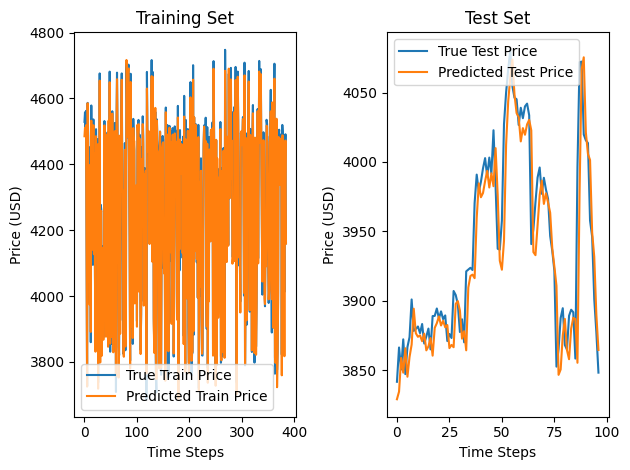

In [35]:
# Plot training predictions
plt.subplot(1, 2, 1)
plt.plot(y_train_orig, label="True Train Price")
plt.plot(train_predictions_orig, label="Predicted Train Price")
plt.title("Training Set")
plt.xlabel("Time Steps")
plt.ylabel("Price (USD)")
plt.legend()

# Plot test predictions
plt.subplot(1, 2, 2)
plt.plot(y_test_orig, label="True Test Price")
plt.plot(test_predictions_orig, label="Predicted Test Price")
plt.title("Test Set")
plt.xlabel("Time Steps")
plt.ylabel("Price (USD)")
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
print("First 10 true test prices:", y_test_orig[:10].flatten())
print("First 10 predicted test prices:", test_predictions_orig[:10].flatten())


First 10 true test prices: [3841.713  3866.4033 3850.5967 3872.2712 3847.2217 3866.731  3873.874
 3900.9944 3878.3687 3879.811 ]
First 10 predicted test prices: [3829.1345 3834.6338 3858.91   3848.273  3865.844  3845.3542 3859.5735
 3868.4998 3894.3374 3876.648 ]


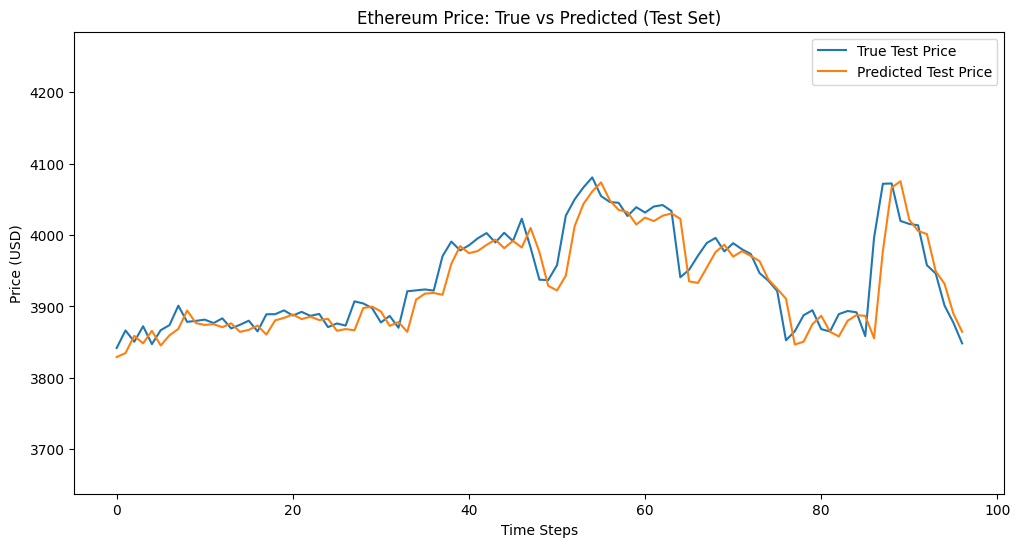

In [37]:
plt.figure(figsize=(12,6))
plt.plot(y_test_orig, label='True Test Price')
plt.plot(test_predictions_orig, label='Predicted Test Price')
plt.title('Ethereum Price: True vs Predicted (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.ylim(min(y_test_orig.min(), test_predictions_orig.min()) * 0.95,
         max(y_test_orig.max(), test_predictions_orig.max()) * 1.05)
plt.show()


In [38]:
from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/Colab Notebooks/collab 1/eth_model.pth"
torch.save(model.state_dict(), save_path)


MessageError: Error: credential propagation was unsuccessful